# Blood Glucose Control - EDA

**Name:** [*Applicant name*]



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

dataframes = []

for patient_csv in os.listdir("../data"):
    if patient_csv.endswith(".csv") and "gluroo_" in patient_csv:
        patient_id = patient_csv.split('_')[1].split('.')[0]
        patient_df = pd.read_csv(f"../data/{patient_csv}")
        patient_df["patient_id"] = patient_id
        dataframes.append(patient_df)

df = pd.concat(dataframes, ignore_index=True)

df.head()

,date,sender_id,bgl,bgl_date_millis,text,template,msg_type,affects_fob,affects_iob,dose_units,food_g,food_glycemic_index,dose_automatic,fp_bgl,message_basal_change,__typename,trend,patient_id
0,2024-05-01 00:00:27.029000-05:00,NaN,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
1,2024-05-01 00:05:27.183000-05:00,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
2,2024-05-01 00:10:26.949000-05:00,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
3,2024-05-01 00:15:27.180000-05:00,NaN,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030
4,2024-05-01 00:20:27.021000-05:00,NaN,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Reading,FLAT,500030


In [2]:
from dateutil import parser

# Standardize date format before converting to datetime
def parse_date(date_str):
    try:
        if pd.isna(date_str):
            return None
        dt = parser.parse(str(date_str))
        return dt.strftime('%Y-%m-%d %H:%M:%S')
    except Exception as e:
        print(f"Failed to parse {date_str}: {e}")
        return None

df['date'] = df['date'].apply(parse_date)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

assert((df['date'].isna()).sum() == 0)

### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet. 

##### Proportion of BGL Levels Across Hours of the Day

This visualization shows the proportion of BGL readings that fall into the three categories—hypoglycemia (low blood sugar), normal range, and hyperglycemia (high blood sugar)—for each hour of the day. 

This will help identify patterns in glucose fluctuations over a 24-hour period, providing insights into when a patient is more likely to experience abnormal blood sugar levels. Such information can then be used to adjust their insulin intake and diet more effectively.

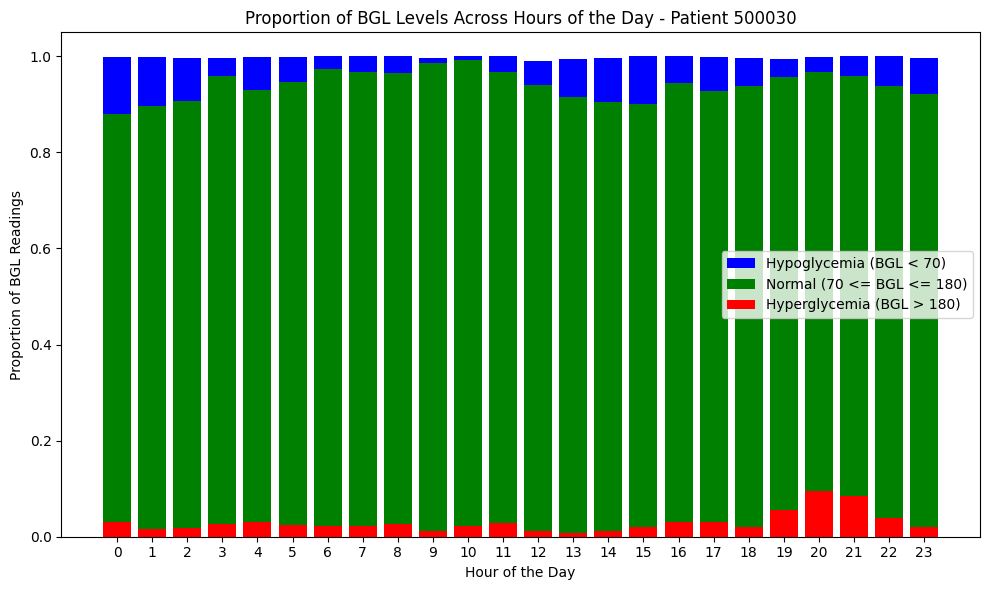

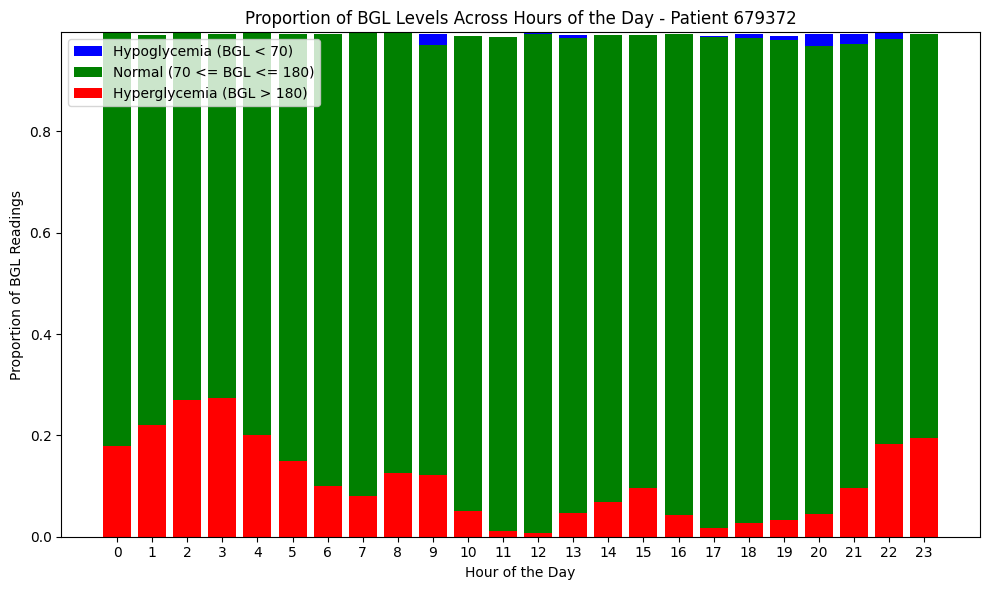

In [3]:
df["hour"] = df["date"].dt.hour

# Define BGL thresholds for hypoglycemia and hyperglycemia
hypoglycemia_threshold = 70
hyperglycemia_threshold = 180

patient_groups = df.groupby("patient_id")

for patient_id, patient_group in patient_groups:
    
    hypoglycemia_proportions = []
    normal_bgl_proportions = []
    hyperglycemia_proportions = []

    # Iterate over each hour of the day 
    # Determine proportions of hypoglycemia, normal and hyperglycemia readings
    for hour in range(24):
        hourly_readings = patient_group[patient_group["hour"] == hour]
        total_readings_count = len(hourly_readings)
        
        if total_readings_count > 0:
            hypoglycemia_proportion = len(hourly_readings[hourly_readings["bgl"] < hypoglycemia_threshold]) / total_readings_count
            normal_bgl_proportion = len(hourly_readings[(hourly_readings["bgl"] >= hypoglycemia_threshold) & (hourly_readings["bgl"] <= hyperglycemia_threshold)]) / total_readings_count
            hyperglycemia_proportion = len(hourly_readings[hourly_readings["bgl"] > hyperglycemia_threshold]) / total_readings_count
        else:
            hypoglycemia_proportion = normal_bgl_proportion = hyperglycemia_proportion = 0
        
        hypoglycemia_proportions.append(hypoglycemia_proportion)
        normal_bgl_proportions.append(normal_bgl_proportion)
        hyperglycemia_proportions.append(hyperglycemia_proportion)

    hours = range(24)
    plt.figure(figsize=(10, 6))

    plt.bar(hours, hypoglycemia_proportions, label="Hypoglycemia (BGL < 70)", color="blue", 
            bottom=[normal + hyper for normal, hyper in zip(normal_bgl_proportions, hyperglycemia_proportions)])
    plt.bar(hours, normal_bgl_proportions, label="Normal (70 <= BGL <= 180)", color="green", 
            bottom=hyperglycemia_proportions)
    plt.bar(hours, hyperglycemia_proportions, label="Hyperglycemia (BGL > 180)", color="red")

    plt.xlabel("Hour of the Day")
    plt.ylabel("Proportion of BGL Readings")
    plt.title(f"Proportion of BGL Levels Across Hours of the Day - Patient {patient_id}")
    plt.xticks(hours)
    plt.legend()

    plt.tight_layout()
    plt.show()

##### Daily Average Blood Glucose Level and Insulin Dose

This visualization displays the daily average BGL and insulin dosage over a 3-month period. 

It enables a PWD to observe how their BGL changes in response to insulin intake, providing insights into the effectiveness of their dosage. These long-term insights could be useful for optimizing insulin management and improving blood glucose control.

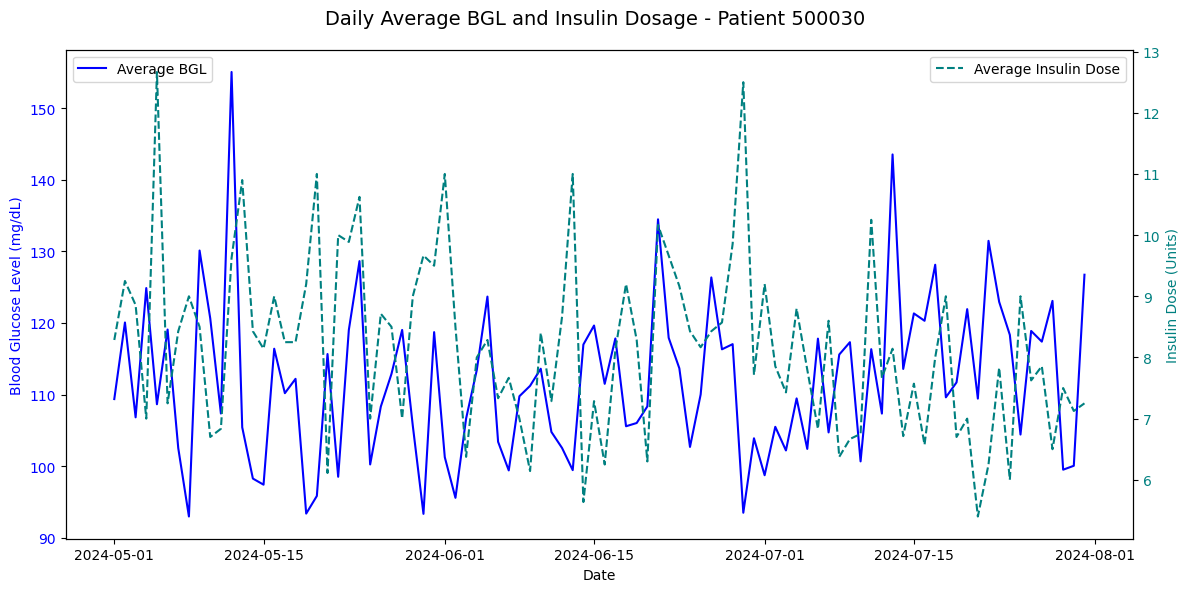

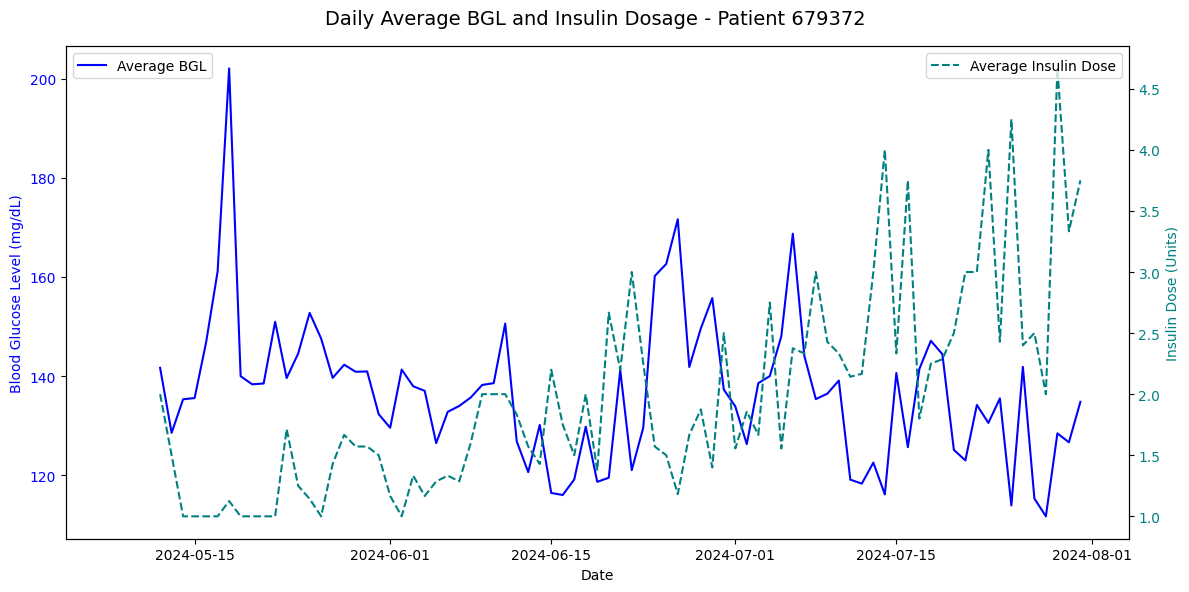

In [4]:
patient_groups = df.groupby("patient_id")

for patient_id, patient_data in patient_groups:

    # Calculate daily averages for both BGL and insulin doses
    daily_avg = patient_data.resample('D', on="date").agg({
        "bgl": "mean",           
        "dose_units": "mean"     
    }).reset_index()              

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Primary y-axis for BGL
    ax1.plot(daily_avg["date"], daily_avg["bgl"], color="blue", label="Average BGL")
    ax1.set_xlabel("Date")                                           
    ax1.set_ylabel("Blood Glucose Level (mg/dL)", color="blue")      
    ax1.tick_params(axis="y", labelcolor="blue")                     

    # Secondary y-axis for insulin dosage
    ax2 = ax1.twinx() 
    ax2.plot(daily_avg["date"], daily_avg["dose_units"], color="teal", label="Average Insulin Dose", linestyle="--")
    ax2.set_ylabel("Insulin Dose (Units)", color="teal")            
    ax2.tick_params(axis="y", labelcolor="teal")                    

    fig.suptitle(f"Daily Average BGL and Insulin Dosage - Patient {patient_id}", fontsize=14)
    ax1.legend(loc="upper left")  
    ax2.legend(loc="upper right") 

    plt.tight_layout()
    plt.show()


### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.* 

1. How does basal insulin compare to bolus insulin in terms of managing blood glucose levels throughout the day? Is one more effective than the other for specific situations or times of day? Are there strategies behind using them together in different dosages to optimize blood sugar control?

2. Are there foods that are considered optimal based on their glycemic index and nutrient profile? Are certain foods recommended for different situations, such as managing hypoglycemia, hyperglycemia, or maintaining stable BGL during normal conditions? 

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future. 

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`